In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from spgl1 import spg_bpdn

In [2]:
def fn1(x):
    return x[1]

def fn2(x):
    return x[3] ** 2 + x[1] * x[2] + x[0] * x[1] + x[3]

def fn3(x):
    return np.sinc(x[0]) * np.sinc(x[2]) ** 3 + np.sinc(x[1])

def fn4(x):
    return np.exp(-x[1]*x[3]) - 3/2.*(x[0]**2)  - 5.*np.sin(x[2]*x[5]) + (1/2.)*x[2]* x[3]* x[4]

def fn5(x):
    return 5*x[1]/np.power(1+x[4],2) + np.sqrt(x[3] + 1)

def fn6(x):
    return (x[1]*x[3])/(1+x[2]**6)

def fn7(x):
    return np.cos(x[1] + x[4])

def fn8(x):
    return x[1] ** 9 - x[1] ** 8 + 7 * x[0] ** 7 + x[1] ** 6 + 3 * x[3] ** 3 - x[4] + 5 + 0.5 * x[2] ** 15

def fn9(x):
    return np.sum(x ** 3) / np.sum(x ** 1.5)

def fn10(x):
    return x[0] ** 2 + np.sum(x)

def fn11(x):
    s = 0
    for i in range(int(len(x)/2)):
        s += x[i]*x[i+1]*x[i+2]

    return s

def fn12(x):
    s = 0
    for i in range(int(len(x)/2)):
        s += np.cos((x[i]*x[i+1]*x[i+2])**2)

    return s

def fn13(x):
    return np.cos(np.prod(x[:int(len(x/2))]))

def fn14(x):
    return np.prod(np.cos(x[:int(len(x/2))])+1)

def fn15(x):
    return np.cos(np.dot(0.1 * np.ones(len(x)), x))

In [3]:
m = 1000
N = 50000
d = 50

mfunction = fn2
noise = 0.0001
ratio_train = 0.75
x_scale = 1
w_scale = 1.5 * np.pi
s = 2
normalize = True
dist = "uniform"

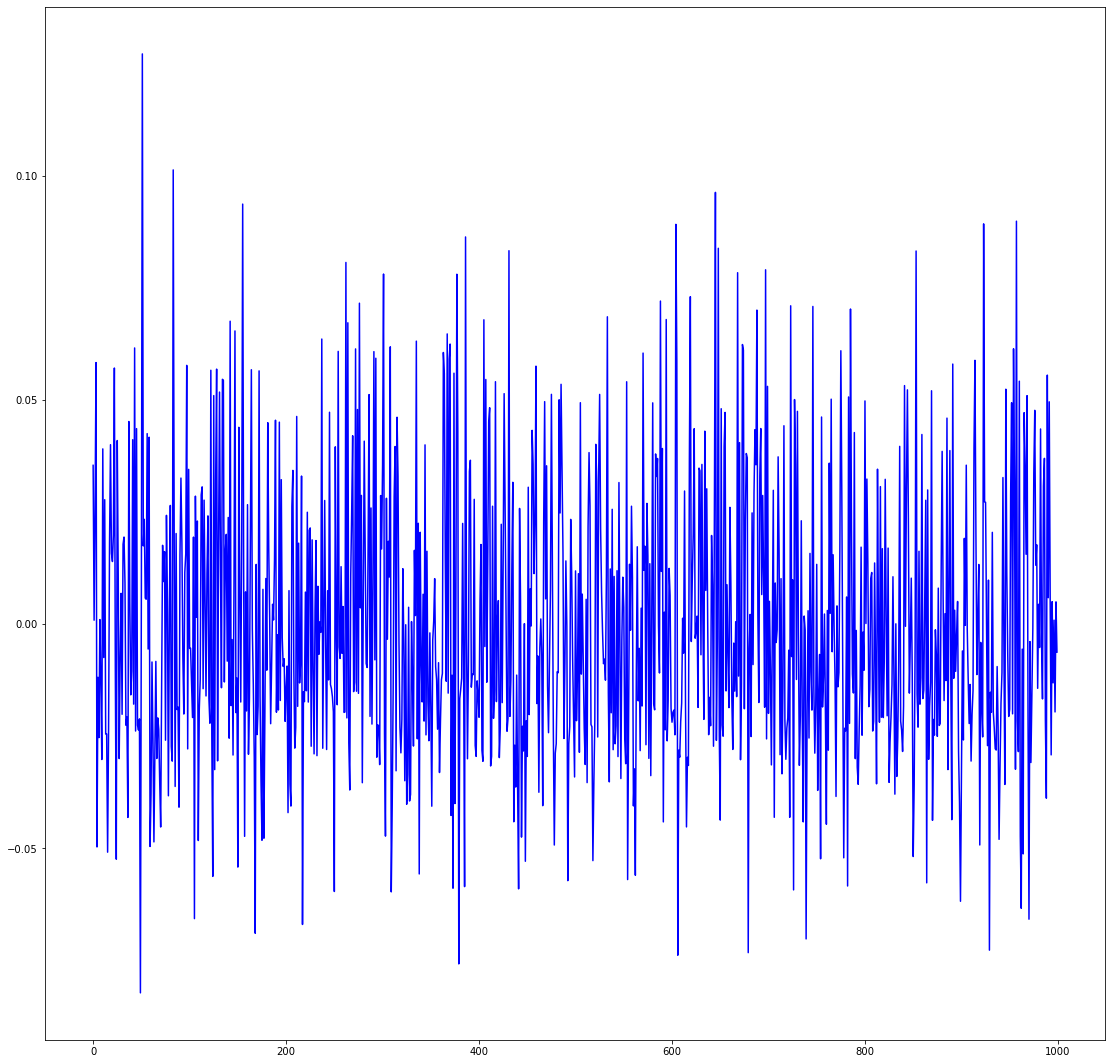

Size of Output Data:  (1000,)
Range of Output Data: [ -0.08221691986255918 , 0.12716161750879282 ]


In [4]:
# Generate Input-Output Data, size: nxd
if dist == "uniform":
    X = x_scale * (2 * np.random.rand(m,d) - 1)
elif dist == "normal":
    X = x_scale * np.random.randn(m,d)

y = np.zeros(m)
for idx in range(m):
    y[idx] = mfunction(X[idx,:])

# Normalize output data to have mean 0 and norm 1
if normalize:
    y -= np.mean(y)
    y_norm = np.sqrt(np.dot(y,y)) 
    y /= y_norm

y += noise*np.random.randn(m)

fig = plt.figure(figsize = (19,19))
plt.plot(y,'b')
plt.show()

# Training and Testing (Input-Output) pairs
X_train = X[0:int(ratio_train*m),:]
X_test = X[int(ratio_train*m):,:]

y_train = y[0:int(ratio_train*m)]
y_test = y[int(ratio_train*m):m]

print("Size of Output Data: ",y.shape)
print("Range of Output Data: [", np.min(y),",", np.max(y),"]")

In [5]:
idx = 0
W = np.zeros((N, d))
b = 0
while (idx<N):
    
    w = w_scale * np.random.randn(d)
    xind = np.random.choice(d,d-s,replace=False)
    w[xind] = 0
    W[idx, :] = w

    idx += 1
            
# Training and Testing input-output pairs        

mult_train = np.matmul(X_train, W.T) + b
mult_test = np.matmul(X_test, W.T) + b

A_train = np.sqrt(2/N) * np.concatenate((np.cos(mult_train), np.sin(mult_train)), axis=1)
A_test = np.sqrt(2/N) * np.concatenate((np.cos(mult_test), np.sin(mult_test)), axis=1)

In [6]:
# L1
c_spgl1, _, _, _ = spg_bpdn(A_train, y_train, sigma=0.1, iter_lim=1e+4, verbosity=0)

In [7]:
ind_spgl1, = c_spgl1.nonzero()
print('\nPercentage of nonzero entries in the coefficient using SPGL1', 100*ind_spgl1.shape[0]/(2*N))


Percentage of nonzero entries in the coefficient using SPGL1 0.601


In [8]:
y_spgl1 = np.matmul(A_train, c_spgl1)
error_train_spgl1 = np.linalg.norm(y_train - y_spgl1)/np.linalg.norm(y_train)
y_test_spgl1 = np.matmul(A_test, c_spgl1)
error_test_spgl1 = np.linalg.norm(y_test - y_test_spgl1)/np.linalg.norm(y_test)

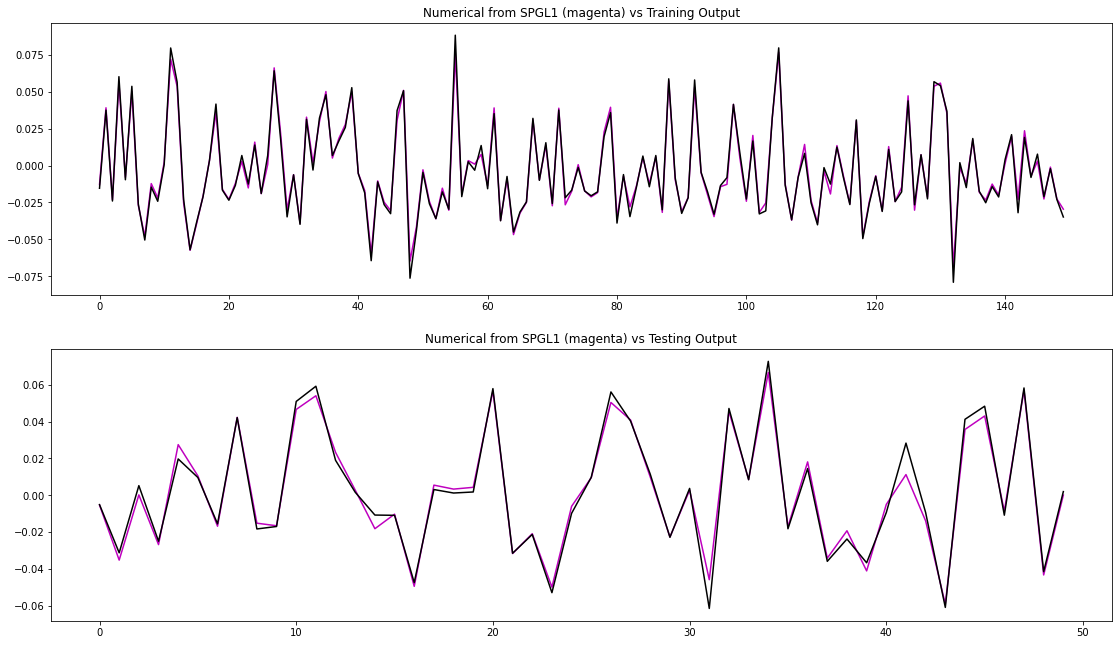

In [9]:
fig = plt.figure(figsize = (19,11))

plt.subplot(2,1,1)
plt.plot(y_spgl1[np.arange(0,len(y_spgl1),5)],'m')
plt.plot(y_train[np.arange(0,len(y_train),5)],'k')
plt.title('Numerical from SPGL1 (magenta) vs Training Output')

plt.subplot(2,1,2)
plt.plot(y_test_spgl1[np.arange(0,len(y_test_spgl1),5)],'m')
plt.plot(y_test[np.arange(0,len(y_test),5)],'k')
plt.title('Numerical from SPGL1 (magenta) vs Testing Output')

plt.show()

In [11]:
gauss_scale = 0.0001
l = 0

sinc_scale = 1 / np.pi

diffs_train = X_train[:, np.newaxis] - X_train
diffs_test = X_train[:, np.newaxis] - X_test

K_gauss = np.exp(-gauss_scale * np.linalg.norm(diffs_train, axis=-1)**2)
a_gauss = np.linalg.solve(K_gauss + l * np.identity(len(K_gauss)), y_train)
y_train_gauss = np.dot(a_gauss, K_gauss)
error_train_gauss = np.linalg.norm(y_train - y_train_gauss)/np.linalg.norm(y_train)
K_test_gauss = np.exp(-k_scale * np.linalg.norm(diffs_test, axis=-1)**2)
y_test_gauss = np.dot(a_gauss, K_test_gauss)
error_test_gauss = np.linalg.norm(y_test - y_test_gauss)/np.linalg.norm(y_test)

K_sinc = (sinc_scale / np.pi) * np.sinc()


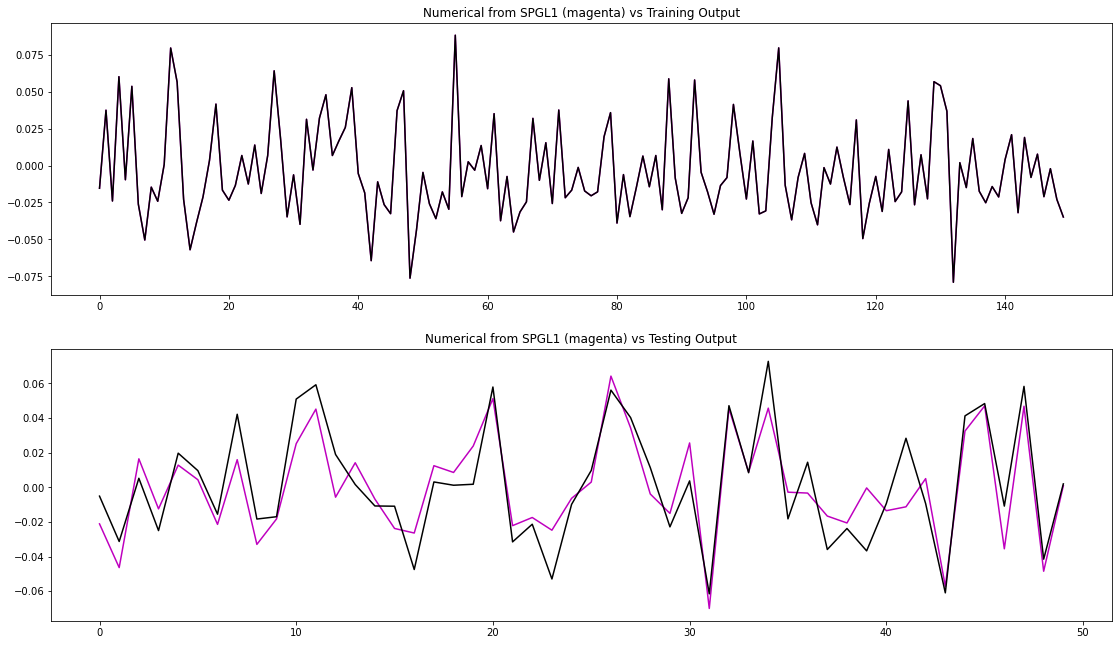

In [12]:
fig = plt.figure(figsize = (19,11))

plt.subplot(2,1,1)
plt.plot(y_train_gauss[np.arange(0,len(y_train_gauss),5)],'m')
plt.plot(y_train[np.arange(0,len(y_train),5)],'k')
plt.title('Numerical from SPGL1 (magenta) vs Training Output')

plt.subplot(2,1,2)
plt.plot(y_test_gauss[np.arange(0,len(y_test_gauss),5)],'m')
plt.plot(y_test[np.arange(0,len(y_test),5)],'k')
plt.title('Numerical from SPGL1 (magenta) vs Testing Output')

plt.show()

In [13]:
print("Sine and cosine")
print('Relative error in training using l1 is ', error_train_spgl1)
print('Relative error in testing using l1 is ', error_test_spgl1)
print("\n--------------------\n")
print('Relative error in training using kernel is ', error_train_gauss)
print('Relative error in testing using kernel is ', error_test_gauss)
print("\n--------------------\n")


Sine and cosine
Relative error in training using l1 is  0.11498819946139409
Relative error in testing using l1 is  0.15269159471540517

--------------------

Relative error in training using kernel is  4.119078356455798e-09
Relative error in testing using kernel is  0.5228768442549908

--------------------

